/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


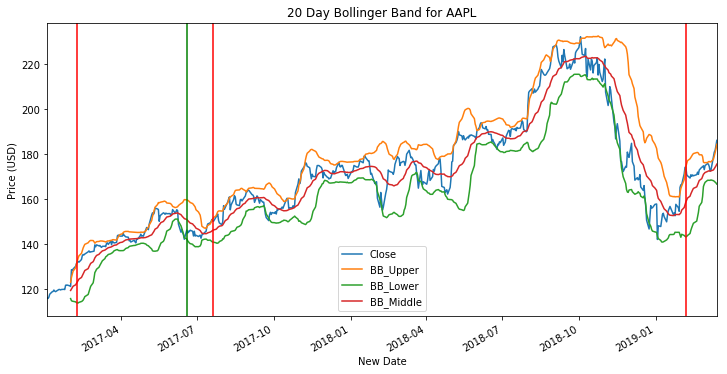

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

#portfolio start value is $100,000
portfolio_value = 100000

# Reading in aapl data
aapl = pd.read_csv("Assignment 3&4-data files/{}.csv".format('AAPL'), usecols=[0, 4],index_col=0)
helper_data = aapl.copy()

# Indicator 4: Bollinger Bands of length 20
# using this resource https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

# Finding 20 day moving average and standard deviation
twentyDay = aapl['Close'].rolling(window=20)
aapl['Daily Return'] = aapl['Close'] / aapl['Close'].shift(periods=-1) - 1
aapl['BB_Middle'] = twentyDay.mean() 
helper_data['20 Day Moving Avg'] = twentyDay.mean() 
# aapl['20 Day Std Dev'] = twentyDay.std()
helper_data['20 Day Std Dev'] = twentyDay.std()

# Finding upper and lower band (moving avg +- 2*std dev)
aapl['BB_Lower'] = aapl['BB_Middle'] - (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Lower'] = helper_data['20 Day Moving Avg'] - (helper_data['20 Day Std Dev'] * 2)
aapl['BB_Upper'] = aapl['BB_Middle'] + (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Upper'] = helper_data['20 Day Moving Avg'] + (helper_data['20 Day Std Dev'] * 2)


# Sellsignal - Closing price crosses below upperband and was above upperband within 5 recent periods (0 or 1)
aapl['Sell_calc'] = aapl['Close'] - aapl['BB_Upper']
aapl['Buy_calc'] = aapl['Close'] - aapl['BB_Lower']
aapl['Buysignal'] = 0
aapl['Sellsignal'] = 0
aapl['Exitsignal'] = 0
aapl['State'] = 0




# Sell signal
for i in range(0, len(aapl)):
    if ((aapl['Sell_calc'].iloc[i] < 0) and (aapl['Sell_calc'].iloc[i-1] > 0) and (aapl['Sell_calc'].iloc[i-2] > 0) and (aapl['Sell_calc'].iloc[i-3] > 0) and (aapl['Sell_calc'].iloc[i-4] > 0) and (aapl['Sell_calc'].iloc[i-5] > 0)):
        aapl['Sellsignal'].iloc[i]=1
#         aapl['Sellsignal'].iloc[i] = aapl['Close'].iloc[i]+10

# Buy signal
for i in range(0, len(aapl)):
    if ((aapl['Buy_calc'].iloc[i] > 0) and (aapl['Buy_calc'].iloc[i-1] < 0) and (aapl['Buy_calc'].iloc[i-2] < 0) and (aapl['Buy_calc'].iloc[i-3] < 0) and (aapl['Buy_calc'].iloc[i-4] < 0) and (aapl['Buy_calc'].iloc[i-5] < 0)):
        aapl['Buysignal'].iloc[i] = 1
#         aapl['Buysignal'].iloc[i] = aapl['Close'].iloc[i]-10




# STATE

# As confirmed with the TA:
# If there is no buy, sell or exit signal, the state should be maintained (stay the same as the state in the previous period).
# If in a long position and there's a buy signal, go into more long positions. 
# If in a long position and there's a sell signal, sell the long position and go into a short position.
# If in a short position and there's a buy signal, sell the short positions and go into a long position. 
# If in a short position and there's a sell signal, buy more short positions. 
# If in a short or long position and there's an exit signal, sell the positions. 



price = 0
num_days = 0
return_val = 0

for i in range(1, len(aapl)):
    
    # maintain previous state
    if(aapl['Sellsignal'].iloc[i]==0 and aapl['Buysignal'].iloc[i]==0):
        aapl['State'].iloc[i]= aapl['State'].iloc[i-1]

    # if previous state in no position, consider buy and sell signal
    if(aapl['State'].iloc[i-1]==0):
        # if you have a buy signal
        if(aapl['Buysignal'].iloc[i]==1):
            # set price to close price of that day
            price = aapl['Close'].iloc[i]
            # increase number of days
            num_days = num_days + 1
            # state is long
            aapl['State'].iloc[i]=1
            
        # if you have a sell signal
        if(aapl['Sellsignal'].iloc[i]==1):
            # set price to close price of that day
            price = aapl['Close'].iloc[i]
            # increase number of days
            num_days = num_days + 1
            # state is short
            aapl['State'].iloc[i]=-1
            
            
    if(aapl['State'].iloc[i-1]==1):
        return_val = (aapl['Close'].iloc[i]-price)/price
        if(return_val > 0.1 or return_val < -0.05):
            aapl['Exitsignal'].iloc[i]=1
            aapl['State'].iloc[i] = 0
        if(aapl['Buysignal'].iloc[i]==1):
            aapl['Exitsignal'].iloc[i]=0
            aapl['State'].iloc[i] = 1  
            price = (price+aapl['Close'].iloc[i])/2
        if(aapl['Sellsignal'].iloc[i]==1):
            aapl['Exitsignal'].iloc[i]=0
            aapl['State'].iloc[i] = -1
            price = aapl['Close'].iloc[i]
        else:
            num_days = num_days + 1
            
    if(aapl['State'].iloc[i-1]==-1):
        return_val = -(aapl['Close'].iloc[i]-price)/price
        if(return_val > 0.1 or return_val < -0.05):
            aapl['Exitsignal'].iloc[i]=1
            aapl['State'].iloc[i] = 0
        if(aapl['Buysignal'].iloc[i]==1):
            aapl['Exitsignal'].iloc[i]=0
            aapl['State'].iloc[i] = 1   
        if(aapl['Sellsignal'].iloc[i]==1):
            aapl['Exitsignal'].iloc[i]=0
            aapl['State'].iloc[i] = -1
        else:
            num_days = num_days + 1

    
        
# Calculating Shares and Portfolio Value
aapl['Shares'] = 0

aapl['Portfolio Value'] = 0

for i in range(1, len(aapl)):
    
    if((aapl['Buysignal'].iloc[i] == 0) and (aapl['Sellsignal'].iloc[i] ==0) and (aapl['Exitsignal'].iloc[i] ==0)):
        aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]
    
    #buy condition when long or no position
    if(aapl['Buysignal'].iloc[i] ==1 and ((aapl['State'].iloc[i-1] == 1) or (aapl['State'].iloc[i-1] == 0))):
        shares_afford_long = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1] + 10
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1] + shares_afford_long
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*shares_afford_long)
    aapl['Portfolio Value'] = portfolio_value
    
    #buy condition when short 
    if((aapl['Buysignal'].iloc[i] ==1) and (aapl['State'].iloc[i-1] == -1)):
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i] = 0

        shares_afford_long = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= 10
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= shares_afford_long
            portfolio_value = portfolio_value - (aapl['Close'].iloc[i]*shares_afford_long)
        aapl['Portfolio Value'] = portfolio_value

    # sell condition when long
    if((aapl['Sellsignal'].iloc[i] ==1) and aapl['State'].iloc[i-1] == 1):
        
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value - aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i] = 0

        shares_afford_short = portfolio_value/aapl['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10

            aapl['Shares'].iloc[i]= - 10
            portfolio_value = portfolio_value + 10*aapl['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= - shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*aapl['Close'].iloc[i]
        aapl['Portfolio Value'] = portfolio_value
    
    # sell condition when short or no position
    if((aapl['Sellsignal'].iloc[i] ==1) and ((aapl['State'].iloc[i-1] == -1) or (aapl['State'].iloc[i-1] == 0))):
        shares_afford_short = portfolio_value / aapl['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]-10
            portfolio_value = portfolio_value + 10*aapl['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            aapl['Shares'].iloc[i]= aapl['Shares'].iloc[i-1]-shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*aapl['Close'].iloc[i]
        aapl['Portfolio Value'] = portfolio_value

                
    # exit condition
    if(aapl['Exitsignal'].iloc[i] ==1 and aapl['State'].iloc[i-1] == 1):
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i]= 0
        aapl['Portfolio Value'] = portfolio_value
        
    if(aapl['Exitsignal'].iloc[i] ==1 and aapl['State'].iloc[i-1] == -1):
        portfolio_value = portfolio_value + aapl['Shares'].iloc[i-1]*aapl['Close'].iloc[i]
        aapl['Shares'].iloc[i]= 0
        aapl['Portfolio Value'] = portfolio_value

        
        

# summary statistics
stat_summary = pd.DataFrame(columns=['Price','State'])
for i in range(1, len(aapl)):
    if (aapl['State'].iloc[i] != aapl['State'].iloc[i-1]):   
        
        
        if(aapl['State'].iloc[i] == -aapl['State'].iloc[i-1]):
            temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
            stat_summary = stat_summary.append(temp_df)
            stat_summary = stat_summary.append(temp_df)
            
        else:
            temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
            stat_summary = stat_summary.append(temp_df)
            
        

        
        
    
    
#     if (aapl['State'].iloc[i] !=0 and aapl['State'].iloc[i-1] == 0):       
#         temp_df = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
#         stat_summary = stat_summary.append(temp_df)

#     if (aapl['State'].iloc[i] == 0 and aapl['State'].iloc[i-1] != 0):
#         temp_df2 = pd.DataFrame({'Price':aapl['Close'].iloc[i],'State':aapl['State'].iloc[i]}, index=[aapl.index[i]])
#         stat_summary = stat_summary.append(temp_df2) 
        
stat_summary['ROI'] = 0
stat_summary['False/True Signal'] = False
# entering position price
start = stat_summary['Price'].iloc[::2]
# leaving position price
end = stat_summary['Price'].iloc[1::2]

stat_summary['Portfolio Value']=0
stat_summary['Shares']=0

# calculate ROI
calc_roi = []
for i in range(0,len(start)):
    calc_roi.append((end[i]-start[i])/start[i])
    
calc_roi = pd.Series(calc_roi)

roi_index = 0
for test in range(1,len(stat_summary),2):
    if(stat_summary['State'].iloc[test-1] == -1):
        stat_summary['ROI'].iloc[test] = -1*calc_roi[roi_index]
    else: 
        stat_summary['ROI'].iloc[test] = calc_roi[roi_index]
    roi_index += 1

roi_index = 0
for test in range(1,len(stat_summary),2):    
    stat_summary['False/True Signal'].iloc[test-1] = ''
    if (stat_summary['ROI'].iloc[test] > 0): 
        stat_summary['False/True Signal'].iloc[test] = True
    roi_index += 1

for test in range(0,len(stat_summary),2):
    date_val = stat_summary.index[test]
    stat_summary['Portfolio Value'].iloc[test] = aapl['Portfolio Value'].loc[date_val]
    stat_summary['Portfolio Value'].iloc[test+1] = aapl['Portfolio Value'].loc[date_val]
    stat_summary['Shares'].iloc[test] = aapl['Shares'].loc[date_val]
    stat_summary['Shares'].iloc[test+1] = aapl['Shares'].loc[date_val]
    


stat_summary_final = pd.DataFrame(columns=['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value', 'Portfolio Ending Value'])
stat_summary_final

for i in range(1,len(stat_summary),2):
    temp_df = pd.DataFrame({'End Date': stat_summary.index[i], 'Start Price': stat_summary['Price'].iloc[i-1],'End Price': stat_summary['Price'].iloc[i],'Start State': stat_summary['State'].iloc[i-1],'End State': stat_summary['State'].iloc[i], 'ROI': stat_summary['ROI'].iloc[i], 'False/True Signal': stat_summary['False/True Signal'].iloc[i], 'Portfolio Starting Value': stat_summary['Portfolio Value'].iloc[i-1], 'Portfolio Ending Value':stat_summary['Portfolio Value'].iloc[i]}, index=[stat_summary.index[i-1]])
    stat_summary_final = stat_summary_final.append(temp_df)

stat_summary_final = stat_summary_final[['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value','Portfolio Ending Value']]    


# df_trades dataframe
df_trades = stat_summary.copy()

df_trades['Position'] = ''
for i in range(0, len(df_trades),2):
    df_trades['Position'].iloc[i]='Entering'
    df_trades['Position'].iloc[i+1]='Exiting'
    df_trades['Shares'].iloc[i+1]=''


# Outputting to csv
aapl.to_csv('BB-aapl-daily-risk-reward-exit.csv')


# Plotting

aapl_new = aapl.copy()
aapl_new['New Date'] = datetime.datetime.strptime(aapl_new.index[0], '%Y-%m-%d')

for i in range(len(aapl_new)):
    aapl_new['New Date'][i] = datetime.datetime.strptime(aapl_new.index[i], '%Y-%m-%d')

# aapl_new = aapl_new.reset_index(drop=True)
aapl_new = aapl_new.reindex(aapl_new['New Date'])



Axes = aapl_new[['Close', 'BB_Upper', 'BB_Lower','BB_Middle']].plot(figsize=(12,6))

# aapl[['Close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].plot(figsize=(12,6))
Axes.set_title('20 Day Bollinger Band for AAPL')
Axes.set_ylabel('Price (USD)')


sells = []
buys = []
for i in range(1, len(aapl_new)):
    if(aapl_new['Sellsignal'].iloc[i]==1):
        sells.append(aapl_new.index[i])
    if(aapl_new['Buysignal'].iloc[i]==1):
        buys.append(aapl_new.index[i])
        
for s in sells:
    # short entry point is red
    Axes.axvline(x=s,color='r')

for b in buys:
    # long entry point is green
    Axes.axvline(x=b,color='g')
    
plt.show()

In [21]:
stat_summary_final

,End Date,Start Price,End Price,Start State,End State,ROI,False/True Signal,Portfolio Starting Value,Portfolio Ending Value
2017-02-08,2017-03-01,132.039993,139.789993,-1,0,-0.058694,False,96776.10015,96776.10015
2017-06-19,2017-07-20,146.339996,150.339996,1,-1,0.027334,True,96776.10015,96776.10015
2017-07-20,2017-08-07,150.339996,158.809998,-1,0,-0.056339,False,96776.10015,96776.10015
2019-02-06,2019-03-14,174.240005,183.729996,-1,0,-0.054465,False,96776.10015,96776.10015


In [22]:
df_trades

,Price,State,ROI,False/True Signal,Portfolio Value,Shares,Position
2017-02-08,132.039993,-1,0.000000,,96776.10015,-10,Entering
2017-03-01,139.789993,0,-0.058694,False,96776.10015,,Exiting
2017-06-19,146.339996,1,0.000000,,96776.10015,10,Entering
2017-07-20,150.339996,-1,0.027334,True,96776.10015,,Exiting
2017-07-20,150.339996,-1,0.000000,,96776.10015,-10,Entering
2017-08-07,158.809998,0,-0.056339,False,96776.10015,,Exiting
2019-02-06,174.240005,-1,0.000000,,96776.10015,-10,Entering
2019-03-14,183.729996,0,-0.054465,False,96776.10015,,Exiting


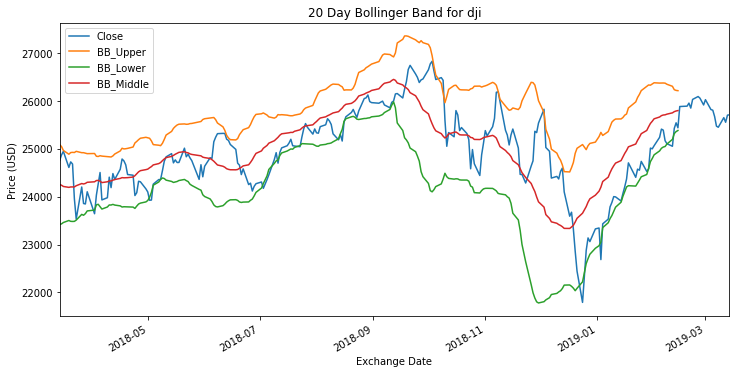

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

#portfolio start value is $100,000
portfolio_value = 100000

# Reading in DJI data
dji = pd.read_excel("Assignment 3&4-data files/{}.xlsx".format('DJI-daily'), skiprows=22,usecols=[0, 1],index_col=0)
helper_data = dji.copy()

# Indicator 4: Bollinger Bands of length 20
# using this resource https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

# Finding 20 day moving average and standard deviation
twentyDay = dji['Close'].rolling(window=20)
dji['Daily Return'] = dji['Close'] / dji['Close'].shift(periods=-1) - 1
dji['BB_Middle'] = twentyDay.mean() 
helper_data['20 Day Moving Avg'] = twentyDay.mean() 
# dji['20 Day Std Dev'] = twentyDay.std()
helper_data['20 Day Std Dev'] = twentyDay.std()

# Finding upper and lower band (moving avg +- 2*std dev)
dji['BB_Lower'] = dji['BB_Middle'] - (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Lower'] = helper_data['20 Day Moving Avg'] - (helper_data['20 Day Std Dev'] * 2)
dji['BB_Upper'] = dji['BB_Middle'] + (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Upper'] = helper_data['20 Day Moving Avg'] + (helper_data['20 Day Std Dev'] * 2)


# Sellsignal - Closing price crosses below upperband and was above upperband within 5 recent periods (0 or 1)
dji['Sell_calc'] = dji['Close'] - dji['BB_Upper']
dji['Buy_calc'] = dji['Close'] - dji['BB_Lower']
dji['Buysignal'] = 0
dji['Sellsignal'] = 0
dji['Exitsignal'] = 0
dji['State'] = 0




# Sell signal
for i in range(0, len(dji)):
    if ((dji['Sell_calc'].iloc[i] < 0) and (dji['Sell_calc'].iloc[i-1] > 0) and (dji['Sell_calc'].iloc[i-2] > 0) and (dji['Sell_calc'].iloc[i-3] > 0) and (dji['Sell_calc'].iloc[i-4] > 0) and (dji['Sell_calc'].iloc[i-5] > 0)):
        dji['Sellsignal'].iloc[i]=1
#         dji['Sellsignal'].iloc[i] = dji['Close'].iloc[i]+10

# Buy signal
for i in range(0, len(dji)):
    if ((dji['Buy_calc'].iloc[i] > 0) and (dji['Buy_calc'].iloc[i-1] < 0) and (dji['Buy_calc'].iloc[i-2] < 0) and (dji['Buy_calc'].iloc[i-3] < 0) and (dji['Buy_calc'].iloc[i-4] < 0) and (dji['Buy_calc'].iloc[i-5] < 0)):
        dji['Buysignal'].iloc[i] = 1
#         dji['Buysignal'].iloc[i] = dji['Close'].iloc[i]-10




# STATE

# As confirmed with the TA:
# If there is no buy, sell or exit signal, the state should be maintained (stay the same as the state in the previous period).
# If in a long position and there's a buy signal, go into more long positions. 
# If in a long position and there's a sell signal, sell the long position and go into a short position.
# If in a short position and there's a buy signal, sell the short positions and go into a long position. 
# If in a short position and there's a sell signal, buy more short positions. 
# If in a short or long position and there's an exit signal, sell the positions. 



price = 0
num_days = 0
return_val = 0

for i in range(1, len(dji)):
    
    # maintain previous state
    if(dji['Sellsignal'].iloc[i]==0 and dji['Buysignal'].iloc[i]==0):
        dji['State'].iloc[i]= dji['State'].iloc[i-1]

    # if previous state in no position, consider buy and sell signal
    if(dji['State'].iloc[i-1]==0):
        # if you have a buy signal
        if(dji['Buysignal'].iloc[i]==1):
            # set price to close price of that day
            price = dji['Close'].iloc[i]
            # increase number of days
            num_days = num_days + 1
            # state is long
            dji['State'].iloc[i]=1
            
        # if you have a sell signal
        if(dji['Sellsignal'].iloc[i]==1):
            # set price to close price of that day
            price = dji['Close'].iloc[i]
            # increase number of days
            num_days = num_days + 1
            # state is short
            dji['State'].iloc[i]=-1
            
            
    if(dji['State'].iloc[i-1]==1):
        return_val = (dji['Close'].iloc[i]-price)/price
        if(return_val > 0.1 or return_val < -0.05):
            dji['Exitsignal'].iloc[i]=1
            dji['State'].iloc[i] = 0
        if(dji['Buysignal'].iloc[i]==1):
            dji['Exitsignal'].iloc[i]=0
            dji['State'].iloc[i] = 1  
            price = (price+dji['Close'].iloc[i])/2
        if(dji['Sellsignal'].iloc[i]==1):
            dji['Exitsignal'].iloc[i]=0
            dji['State'].iloc[i] = -1
            price = dji['Close'].iloc[i]
        else:
            num_days = num_days + 1
            
    if(dji['State'].iloc[i-1]==-1):
        return_val = -(dji['Close'].iloc[i]-price)/price
        if(return_val > 0.1 or return_val < -0.05):
            dji['Exitsignal'].iloc[i]=1
            dji['State'].iloc[i] = 0
        if(dji['Buysignal'].iloc[i]==1):
            dji['Exitsignal'].iloc[i]=0
            dji['State'].iloc[i] = 1   
        if(dji['Sellsignal'].iloc[i]==1):
            dji['Exitsignal'].iloc[i]=0
            dji['State'].iloc[i] = -1
        else:
            num_days = num_days + 1

    
        
# Calculating Shares and Portfolio Value
dji['Shares'] = 0

dji['Portfolio Value'] = 0

for i in range(1, len(dji)):
    
    if((dji['Buysignal'].iloc[i] == 0) and (dji['Sellsignal'].iloc[i] ==0) and (dji['Exitsignal'].iloc[i] ==0)):
        dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1]
    
    #buy condition when long or no position
    if(dji['Buysignal'].iloc[i] ==1 and ((dji['State'].iloc[i-1] == 1) or (dji['State'].iloc[i-1] == 0))):
        shares_afford_long = portfolio_value/dji['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1] + 10
            portfolio_value = portfolio_value - (dji['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1] + shares_afford_long
            portfolio_value = portfolio_value - (dji['Close'].iloc[i]*shares_afford_long)
    dji['Portfolio Value'] = portfolio_value
    
    #buy condition when short 
    if((dji['Buysignal'].iloc[i] ==1) and (dji['State'].iloc[i-1] == -1)):
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value + dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i] = 0

        shares_afford_long = portfolio_value/dji['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            dji['Shares'].iloc[i]= 10
            portfolio_value = portfolio_value - (dji['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            dji['Shares'].iloc[i]= shares_afford_long
            portfolio_value = portfolio_value - (dji['Close'].iloc[i]*shares_afford_long)
        dji['Portfolio Value'] = portfolio_value

    # sell condition when long
    if((dji['Sellsignal'].iloc[i] ==1) and dji['State'].iloc[i-1] == 1):
        
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value - dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i] = 0

        shares_afford_short = portfolio_value/dji['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10

            dji['Shares'].iloc[i]= - 10
            portfolio_value = portfolio_value + 10*dji['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            dji['Shares'].iloc[i]= - shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*dji['Close'].iloc[i]
        dji['Portfolio Value'] = portfolio_value
    
    # sell condition when short or no position
    if((dji['Sellsignal'].iloc[i] ==1) and ((dji['State'].iloc[i-1] == -1) or (dji['State'].iloc[i-1] == 0))):
        shares_afford_short = portfolio_value / dji['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10
            dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1]-10
            portfolio_value = portfolio_value + 10*dji['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            dji['Shares'].iloc[i]= dji['Shares'].iloc[i-1]-shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*dji['Close'].iloc[i]
        dji['Portfolio Value'] = portfolio_value

                
    # exit condition
    if(dji['Exitsignal'].iloc[i] ==1 and dji['State'].iloc[i-1] == 1):
        portfolio_value = portfolio_value + dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i]= 0
        dji['Portfolio Value'] = portfolio_value
        
    if(dji['Exitsignal'].iloc[i] ==1 and dji['State'].iloc[i-1] == -1):
        portfolio_value = portfolio_value + dji['Shares'].iloc[i-1]*dji['Close'].iloc[i]
        dji['Shares'].iloc[i]= 0
        dji['Portfolio Value'] = portfolio_value

        
        

# summary statistics
stat_summary = pd.DataFrame(columns=['Price','State'])
for i in range(1, len(dji)):
    if (dji['State'].iloc[i] != dji['State'].iloc[i-1]):   
        
        
        if(dji['State'].iloc[i] == -dji['State'].iloc[i-1]):
            temp_df = pd.DataFrame({'Price':dji['Close'].iloc[i],'State':dji['State'].iloc[i]}, index=[dji.index[i]])
            stat_summary = stat_summary.append(temp_df)
            stat_summary = stat_summary.append(temp_df)
            
        else:
            temp_df = pd.DataFrame({'Price':dji['Close'].iloc[i],'State':dji['State'].iloc[i]}, index=[dji.index[i]])
            stat_summary = stat_summary.append(temp_df)
            
        

        
        
    
    
#     if (dji['State'].iloc[i] !=0 and dji['State'].iloc[i-1] == 0):       
#         temp_df = pd.DataFrame({'Price':dji['Close'].iloc[i],'State':dji['State'].iloc[i]}, index=[dji.index[i]])
#         stat_summary = stat_summary.append(temp_df)

#     if (dji['State'].iloc[i] == 0 and dji['State'].iloc[i-1] != 0):
#         temp_df2 = pd.DataFrame({'Price':dji['Close'].iloc[i],'State':dji['State'].iloc[i]}, index=[dji.index[i]])
#         stat_summary = stat_summary.append(temp_df2) 
        
stat_summary['ROI'] = 0
stat_summary['False/True Signal'] = False
# entering position price
start = stat_summary['Price'].iloc[::2]
# leaving position price
end = stat_summary['Price'].iloc[1::2]

stat_summary['Portfolio Value']=0
stat_summary['Shares']=0

# calculate ROI
calc_roi = []
for i in range(0,len(start)):
    calc_roi.append((end[i]-start[i])/start[i])
    
calc_roi = pd.Series(calc_roi)

roi_index = 0
for test in range(1,len(stat_summary),2):
    if(stat_summary['State'].iloc[test-1] == -1):
        stat_summary['ROI'].iloc[test] = -1*calc_roi[roi_index]
    else: 
        stat_summary['ROI'].iloc[test] = calc_roi[roi_index]
    roi_index += 1

roi_index = 0
for test in range(1,len(stat_summary),2):    
    stat_summary['False/True Signal'].iloc[test-1] = ''
    if (stat_summary['ROI'].iloc[test] > 0): 
        stat_summary['False/True Signal'].iloc[test] = True
    roi_index += 1

for test in range(0,len(stat_summary),2):
    date_val = stat_summary.index[test]
    stat_summary['Portfolio Value'].iloc[test] = dji['Portfolio Value'].loc[date_val]
    stat_summary['Portfolio Value'].iloc[test+1] = dji['Portfolio Value'].loc[date_val]
    stat_summary['Shares'].iloc[test] = dji['Shares'].loc[date_val]
    stat_summary['Shares'].iloc[test+1] = dji['Shares'].loc[date_val]
    


stat_summary_final = pd.DataFrame(columns=['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value', 'Portfolio Ending Value'])
stat_summary_final

for i in range(1,len(stat_summary),2):
    temp_df = pd.DataFrame({'End Date': stat_summary.index[i], 'Start Price': stat_summary['Price'].iloc[i-1],'End Price': stat_summary['Price'].iloc[i],'Start State': stat_summary['State'].iloc[i-1],'End State': stat_summary['State'].iloc[i], 'ROI': stat_summary['ROI'].iloc[i], 'False/True Signal': stat_summary['False/True Signal'].iloc[i], 'Portfolio Starting Value': stat_summary['Portfolio Value'].iloc[i-1], 'Portfolio Ending Value':stat_summary['Portfolio Value'].iloc[i]}, index=[stat_summary.index[i-1]])
    stat_summary_final = stat_summary_final.append(temp_df)

stat_summary_final = stat_summary_final[['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value','Portfolio Ending Value']]    


# df_trades dataframe
df_trades = stat_summary.copy()

df_trades['Position'] = ''
for i in range(0, len(df_trades),2):
    df_trades['Position'].iloc[i]='Entering'
    df_trades['Position'].iloc[i+1]='Exiting'
    df_trades['Shares'].iloc[i+1]=''


# Outputting to csv
dji.to_csv('BB-dji-daily-risk-reward-exit.csv')


# Plotting

dji_new = dji.copy()
# dji_new['New Date'] = datetime.datetime.strptime(dji_new.index[0], '%Y-%m-%d')

# for i in range(len(dji_new)):
#     dji_new['Date'][i] = datetime.datetime.strptime(dji_new.index[i], '%Y-%m-%d')

# # dji_new = dji_new.reset_index(drop=True)
# dji_new = dji_new.reindex(dji_new['New Date'])



Axes = dji_new[['Close', 'BB_Upper', 'BB_Lower','BB_Middle']].plot(figsize=(12,6))

# dji[['Close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].plot(figsize=(12,6))
Axes.set_title('20 Day Bollinger Band for dji')
Axes.set_ylabel('Price (USD)')


sells = []
buys = []
for i in range(1, len(dji_new)):
    if(dji_new['Sellsignal'].iloc[i]==1):
        sells.append(dji_new.index[i])
    if(dji_new['Buysignal'].iloc[i]==1):
        buys.append(dji_new.index[i])
        
for s in sells:
    # short entry point is red
    Axes.axvline(x=s,color='r')

for b in buys:
    # long entry point is green
    Axes.axvline(x=b,color='g')
    
plt.show()

In [46]:
stat_summary_final

,End Date,Start Price,End Price,Start State,End State,ROI,False/True Signal,Portfolio Starting Value,Portfolio Ending Value


In [47]:
df_trades

,Price,State,ROI,False/True Signal,Portfolio Value,Shares,Position


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

#portfolio start value is $100,000
portfolio_value = 100000

# Reading in spx data
spx = pd.read_excel("Assignment 3&4-data files/{}.xlsx".format('SPX-5min'), skiprows=13,usecols=[0,2],index_col=0)
helper_data = spx.copy()

# Indicator 4: Bollinger Bands of length 20
# using this resource https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

# Finding 20 day moving average and standard deviation
twentyDay = spx['Close'].rolling(window=20)
spx['Daily Return'] = spx['Close'] / spx['Close'].shift(periods=-1) - 1
spx['BB_Middle'] = twentyDay.mean() 
helper_data['20 Day Moving Avg'] = twentyDay.mean() 
# spx['20 Day Std Dev'] = twentyDay.std()
helper_data['20 Day Std Dev'] = twentyDay.std()

# Finding upper and lower band (moving avg +- 2*std dev)
spx['BB_Lower'] = spx['BB_Middle'] - (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Lower'] = helper_data['20 Day Moving Avg'] - (helper_data['20 Day Std Dev'] * 2)
spx['BB_Upper'] = spx['BB_Middle'] + (helper_data['20 Day Std Dev'] * 2)
helper_data['BB_Upper'] = helper_data['20 Day Moving Avg'] + (helper_data['20 Day Std Dev'] * 2)


# Sellsignal - Closing price crosses below upperband and was above upperband within 5 recent periods (0 or 1)
spx['Sell_calc'] = spx['Close'] - spx['BB_Upper']
spx['Buy_calc'] = spx['Close'] - spx['BB_Lower']
spx['Buysignal'] = 0
spx['Sellsignal'] = 0
spx['Exitsignal'] = 0
spx['State'] = 0




# Sell signal
for i in range(0, len(spx)):
    if ((spx['Sell_calc'].iloc[i] < 0) and (spx['Sell_calc'].iloc[i-1] > 0) and (spx['Sell_calc'].iloc[i-2] > 0) and (spx['Sell_calc'].iloc[i-3] > 0) and (spx['Sell_calc'].iloc[i-4] > 0) and (spx['Sell_calc'].iloc[i-5] > 0)):
        spx['Sellsignal'].iloc[i]=1
#         spx['Sellsignal'].iloc[i] = spx['Close'].iloc[i]+10

# Buy signal
for i in range(0, len(spx)):
    if ((spx['Buy_calc'].iloc[i] > 0) and (spx['Buy_calc'].iloc[i-1] < 0) and (spx['Buy_calc'].iloc[i-2] < 0) and (spx['Buy_calc'].iloc[i-3] < 0) and (spx['Buy_calc'].iloc[i-4] < 0) and (spx['Buy_calc'].iloc[i-5] < 0)):
        spx['Buysignal'].iloc[i] = 1
#         spx['Buysignal'].iloc[i] = spx['Close'].iloc[i]-10




# STATE

# As confirmed with the TA:
# If there is no buy, sell or exit signal, the state should be maintained (stay the same as the state in the previous period).
# If in a long position and there's a buy signal, go into more long positions. 
# If in a long position and there's a sell signal, sell the long position and go into a short position.
# If in a short position and there's a buy signal, sell the short positions and go into a long position. 
# If in a short position and there's a sell signal, buy more short positions. 
# If in a short or long position and there's an exit signal, sell the positions. 



price = 0
num_days = 0
return_val = 0

for i in range(1, len(spx)):
    
    # maintain previous state
    if(spx['Sellsignal'].iloc[i]==0 and spx['Buysignal'].iloc[i]==0):
        spx['State'].iloc[i]= spx['State'].iloc[i-1]

    # if previous state in no position, consider buy and sell signal
    if(spx['State'].iloc[i-1]==0):
        # if you have a buy signal
        if(spx['Buysignal'].iloc[i]==1):
            # set price to close price of that day
            price = spx['Close'].iloc[i]
            # increase number of days
            num_days = num_days + 1
            # state is long
            spx['State'].iloc[i]=1
            
        # if you have a sell signal
        if(spx['Sellsignal'].iloc[i]==1):
            # set price to close price of that day
            price = spx['Close'].iloc[i]
            # increase number of days
            num_days = num_days + 1
            # state is short
            spx['State'].iloc[i]=-1
            
            
    if(spx['State'].iloc[i-1]==1):
        return_val = (spx['Close'].iloc[i]-price)/price
        if(return_val > 0.1 or return_val < -0.05):
            spx['Exitsignal'].iloc[i]=1
            spx['State'].iloc[i] = 0
        if(spx['Buysignal'].iloc[i]==1):
            spx['Exitsignal'].iloc[i]=0
            spx['State'].iloc[i] = 1  
            price = (price+spx['Close'].iloc[i])/2
        if(spx['Sellsignal'].iloc[i]==1):
            spx['Exitsignal'].iloc[i]=0
            spx['State'].iloc[i] = -1
            price = spx['Close'].iloc[i]
        else:
            num_days = num_days + 1
            
    if(spx['State'].iloc[i-1]==-1):
        return_val = -(spx['Close'].iloc[i]-price)/price
        if(return_val > 0.1 or return_val < -0.05):
            spx['Exitsignal'].iloc[i]=1
            spx['State'].iloc[i] = 0
        if(spx['Buysignal'].iloc[i]==1):
            spx['Exitsignal'].iloc[i]=0
            spx['State'].iloc[i] = 1   
        if(spx['Sellsignal'].iloc[i]==1):
            spx['Exitsignal'].iloc[i]=0
            spx['State'].iloc[i] = -1
        else:
            num_days = num_days + 1

    
        
# Calculating Shares and Portfolio Value
spx['Shares'] = 0

spx['Portfolio Value'] = 0

for i in range(1, len(spx)):
    
    if((spx['Buysignal'].iloc[i] == 0) and (spx['Sellsignal'].iloc[i] ==0) and (spx['Exitsignal'].iloc[i] ==0)):
        spx['Shares'].iloc[i]= spx['Shares'].iloc[i-1]
    
    #buy condition when long or no position
    if(spx['Buysignal'].iloc[i] ==1 and ((spx['State'].iloc[i-1] == 1) or (spx['State'].iloc[i-1] == 0))):
        shares_afford_long = portfolio_value/spx['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            spx['Shares'].iloc[i]= spx['Shares'].iloc[i-1] + 10
            portfolio_value = portfolio_value - (spx['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            spx['Shares'].iloc[i]= spx['Shares'].iloc[i-1] + shares_afford_long
            portfolio_value = portfolio_value - (spx['Close'].iloc[i]*shares_afford_long)
    spx['Portfolio Value'] = portfolio_value
    
    #buy condition when short 
    if((spx['Buysignal'].iloc[i] ==1) and (spx['State'].iloc[i-1] == -1)):
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value + spx['Shares'].iloc[i-1]*spx['Close'].iloc[i]
        spx['Shares'].iloc[i] = 0

        shares_afford_long = portfolio_value/spx['Close'].iloc[i]
        if (shares_afford_long >= 10):
            # if you can afford 10 shares, buy 10
            spx['Shares'].iloc[i]= 10
            portfolio_value = portfolio_value - (spx['Close'].iloc[i]*10)
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            spx['Shares'].iloc[i]= shares_afford_long
            portfolio_value = portfolio_value - (spx['Close'].iloc[i]*shares_afford_long)
        spx['Portfolio Value'] = portfolio_value

    # sell condition when long
    if((spx['Sellsignal'].iloc[i] ==1) and spx['State'].iloc[i-1] == 1):
        
        # Selling all short positions, so number of shares becomes 0
        portfolio_value = portfolio_value - spx['Shares'].iloc[i-1]*spx['Close'].iloc[i]
        spx['Shares'].iloc[i] = 0

        shares_afford_short = portfolio_value/spx['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10

            spx['Shares'].iloc[i]= - 10
            portfolio_value = portfolio_value + 10*spx['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            spx['Shares'].iloc[i]= - shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*spx['Close'].iloc[i]
        spx['Portfolio Value'] = portfolio_value
    
    # sell condition when short or no position
    if((spx['Sellsignal'].iloc[i] ==1) and ((spx['State'].iloc[i-1] == -1) or (spx['State'].iloc[i-1] == 0))):
        shares_afford_short = portfolio_value / spx['Close'].iloc[i]
        if (shares_afford_short >= 10):
            # if you can afford 10 shares, buy 10
            spx['Shares'].iloc[i]= spx['Shares'].iloc[i-1]-10
            portfolio_value = portfolio_value + 10*spx['Close'].iloc[i]
        else:
            # if you can't afford 10 shares, buy as many as you can afford
            spx['Shares'].iloc[i]= spx['Shares'].iloc[i-1]-shares_afford_short
            portfolio_value = portfolio_value + shares_afford_short*spx['Close'].iloc[i]
        spx['Portfolio Value'] = portfolio_value

                
    # exit condition
    if(spx['Exitsignal'].iloc[i] ==1 and spx['State'].iloc[i-1] == 1):
        portfolio_value = portfolio_value + spx['Shares'].iloc[i-1]*spx['Close'].iloc[i]
        spx['Shares'].iloc[i]= 0
        spx['Portfolio Value'] = portfolio_value
        
    if(spx['Exitsignal'].iloc[i] ==1 and spx['State'].iloc[i-1] == -1):
        portfolio_value = portfolio_value + spx['Shares'].iloc[i-1]*spx['Close'].iloc[i]
        spx['Shares'].iloc[i]= 0
        spx['Portfolio Value'] = portfolio_value

        
        

# summary statistics
stat_summary = pd.DataFrame(columns=['Price','State'])
for i in range(1, len(spx)):
    if (spx['State'].iloc[i] != spx['State'].iloc[i-1]):   
        
        
        if(spx['State'].iloc[i] == 1 and spx['State'].iloc[i-1] == -1):
            temp_df = pd.DataFrame({'Price':spx['Close'].iloc[i],'State':spx['State'].iloc[i]}, index=[spx.index[i]])
            stat_summary = stat_summary.append(temp_df)
            stat_summary = stat_summary.append(temp_df)
    
        if(spx['State'].iloc[i] == -1 and spx['State'].iloc[i-1] == 1):
            temp_df = pd.DataFrame({'Price':spx['Close'].iloc[i],'State':spx['State'].iloc[i]}, index=[spx.index[i]])
            stat_summary = stat_summary.append(temp_df)
            stat_summary = stat_summary.append(temp_df)

        if (spx['State'].iloc[i] !=0 and spx['State'].iloc[i-1] == 0):       
            temp_df = pd.DataFrame({'Price':spx['Close'].iloc[i],'State':spx['State'].iloc[i]}, index=[spx.index[i]])
            stat_summary = stat_summary.append(temp_df)

        if (spx['State'].iloc[i] == 0 and spx['State'].iloc[i-1] != 0):
            temp_df2 = pd.DataFrame({'Price':spx['Close'].iloc[i],'State':spx['State'].iloc[i]}, index=[spx.index[i]])
            stat_summary = stat_summary.append(temp_df2) 
        
        else:
            temp_df = pd.DataFrame({'Price':spx['Close'].iloc[i],'State':spx['State'].iloc[i]}, index=[spx.index[i]])
            stat_summary = stat_summary.append(temp_df)
            
stat_summary['ROI'] = 0
stat_summary['False/True Signal'] = False
# entering position price
start = stat_summary['Price'].iloc[::2]
# leaving position price
end = stat_summary['Price'].iloc[1::2]

stat_summary['Portfolio Value']=0
stat_summary['Shares']=0

# calculate ROI
calc_roi = []
for i in range(0,len(start)):
    calc_roi.append((end[i]-start[i])/start[i])
    
calc_roi = pd.Series(calc_roi)

roi_index = 0
for test in range(1,len(stat_summary),2):
    if(stat_summary['State'].iloc[test-1] == -1):
        stat_summary['ROI'].iloc[test] = -1*calc_roi[roi_index]
    else: 
        stat_summary['ROI'].iloc[test] = calc_roi[roi_index]
    roi_index += 1

roi_index = 0
for test in range(1,len(stat_summary),2):    
    stat_summary['False/True Signal'].iloc[test-1] = ''
    if (stat_summary['ROI'].iloc[test] > 0): 
        stat_summary['False/True Signal'].iloc[test] = True
    roi_index += 1

for test in range(0,len(stat_summary),2):
    date_val = stat_summary.index[test]
    stat_summary['Portfolio Value'].iloc[test] = spx['Portfolio Value'].loc[date_val]
    stat_summary['Portfolio Value'].iloc[test+1] = spx['Portfolio Value'].loc[date_val]
    stat_summary['Shares'].iloc[test] = spx['Shares'].loc[date_val]
    stat_summary['Shares'].iloc[test+1] = spx['Shares'].loc[date_val]
    


stat_summary_final = pd.DataFrame(columns=['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value', 'Portfolio Ending Value'])
stat_summary_final

for i in range(1,len(stat_summary),2):
    temp_df = pd.DataFrame({'End Date': stat_summary.index[i], 'Start Price': stat_summary['Price'].iloc[i-1],'End Price': stat_summary['Price'].iloc[i],'Start State': stat_summary['State'].iloc[i-1],'End State': stat_summary['State'].iloc[i], 'ROI': stat_summary['ROI'].iloc[i], 'False/True Signal': stat_summary['False/True Signal'].iloc[i], 'Portfolio Starting Value': stat_summary['Portfolio Value'].iloc[i-1], 'Portfolio Ending Value':stat_summary['Portfolio Value'].iloc[i]}, index=[stat_summary.index[i-1]])
    stat_summary_final = stat_summary_final.append(temp_df)

stat_summary_final = stat_summary_final[['End Date','Start Price','End Price','Start State', 'End State', 'ROI', 'False/True Signal','Portfolio Starting Value','Portfolio Ending Value']]    


# df_trades dataframe
df_trades = stat_summary.copy()

df_trades['Position'] = ''
for i in range(0, len(df_trades),2):
    df_trades['Position'].iloc[i]='Entering'
    df_trades['Position'].iloc[i+1]='Exiting'
    df_trades['Shares'].iloc[i+1]=''


# Outputting to csv
spx.to_csv('BB-spx-daily-risk-reward-exit.csv')


# Plotting

spx_new = spx.copy()
# spx_new['New Date'] = datetime.datetime.strptime(spx_new.index[0], '%Y-%m-%d')

# for i in range(len(spx_new)):
#     spx_new['Date'][i] = datetime.datetime.strptime(spx_new.index[i], '%Y-%m-%d')

# # spx_new = spx_new.reset_index(drop=True)
# spx_new = spx_new.reindex(spx_new['New Date'])



Axes = spx_new[['Close', 'BB_Upper', 'BB_Lower','BB_Middle']].plot(figsize=(12,6))

# spx[['Close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].plot(figsize=(12,6))
Axes.set_title('20 Day Bollinger Band for spx')
Axes.set_ylabel('Price (USD)')


sells = []
buys = []
for i in range(1, len(spx_new)):
    if(spx_new['Sellsignal'].iloc[i]==1):
        sells.append(spx_new.index[i])
    if(spx_new['Buysignal'].iloc[i]==1):
        buys.append(spx_new.index[i])
        
for s in sells:
    # short entry point is red
    Axes.axvline(x=s,color='r')

for b in buys:
    # long entry point is green
    Axes.axvline(x=b,color='g')
    
plt.show()

IndexError: index out of bounds

In [ ]:
stat_summary_final

In [ ]:
df_trades

In [ ]:
stat_summary

In [ ]:
start

In [ ]:
end